## **순환 신경망으로 IMDB 리뷰 분류(긍정,부정)하기**


## IMDB 리뷰 데이터셋

이 데이터셋은 유명한 인터넷 영화 데이터베이스 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋이다.

총 50,000개의 샘플로 이루어져 있고 훈련 데이터와 테스트 데이터에 각각 25,000개씩 나누어져 있다.

### 신경망에 텍스트를 전달하는 방법

컴퓨터에서 처리하는 것은 어떤 숫자 데이터이다. 텍스트 데이터의 경우 단어를 숫자 데이터로 바꿔야 한다. 한 가지 방법은 데이터(말뭉치)에 등장하는 단어마다 고유한 정수를 부여하는 것이다.

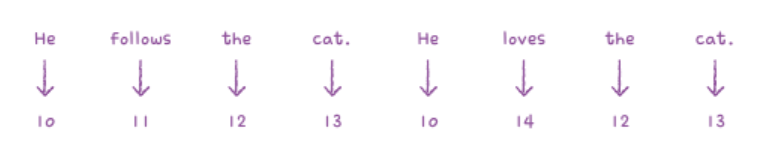

동일한 단어는 동일한 정수에 매핑된다. 이렇게 인덱스를 통해 매핑하면 정수값 사이에는 어떠한 관계도 없다.

영어 문장의 경우 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리한다. 이렇게 분리된 단어를 토큰(token)이라고 부른다.

보통 하나의 셈플은 여러 개의 토큰으로 이루어져 있고, **1개의 토큰이 하나의 타입스텝**에 해당한다.

또한 토큰에 할당하는 정수 중, 몇 개는 특별한 용도로 사용하기 위해 예약된 경우가 많다. 보통 0은 패딩, 1은 문장의 시작, 2는 어휘 사전에 없는 토큰을 나타낸다.

(텐서플로에는 이미 정수로 바꾼 데이터가 포함되어 있다.)

### IMDB 데이터 가져오기

In [7]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500) # 어휘 사전에는 500개의 단어(등장 횟수 중 가장 많이 등장한 단어)

In [3]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


그런데 훈련 배열이 1차원이다. 이는 리뷰 텍스트 길이가 제각가이기 때문이다. 따라서 고정 크기의 2차원 배열에 담기보다 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있다.

그러므로 이 데이터는 개별 리뷰를 다음 넘파이 배열인 것이다.

In [5]:
# 첫 번째 리뷰의 길이
print(len(train_input[0]))
# 두 번째 리뷰의 길이
print(len(train_input[1]))

218
189


In [6]:
# 첫 번째 배열에 담긴 내용
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


한 단어가 한 정수에 매핑되어 표현되는 것을 볼 수 있다. 

사전에 없는 단어는 모두 2로 표시되어 나타난다.

In [8]:
# 타깃 데이터
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


0은 부정, 1은 긍정(이진 분류)

### 훈련 세트에서 검증 세트 떼기

원래 훈련 세트의 크기가 25,000개인데 20%를 검증 세트로 떼어놓을 것이다.

In [9]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state=42)

### 데이터셋 조사

In [11]:
# 각 리뷰의 길이 따로 저장하기
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [12]:
# 리뷰 길이의 평균값과 중간값
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


리뷰의 평균 단어수는 239개이고 중간값이 178인 것으로 보아 이 리뷰 길이 데이터는 한쪽에 치우친 분포를 보일 것이다.

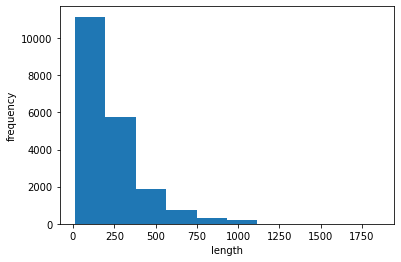

In [13]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

보다시피 대부분의 리뷰의 길이는 300단어 미만이다. 평균이 중간값보다 높은 이유는 오른쪽 긑에 아주 큰 데이터가 있기 때문이다. 

리뷰가 대부분 짧으므로 이 예제에서는 100개의 단어만 사용할 것이다. 100단어보다 작은 리뷰는 길이를 100으로 맞추기 위해 0으로 패딩을 줄 것이다.

수동으로 리뷰를 순회하면서 100이 되도록 자르고, 0으로 패딩할 수 있다. 하지만 케라스의 pad_sequences()를 사용하면 편리하다.

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

In [15]:
print(train_seq.shape)

(20000, 100)


이제 1차원의 파이썬 리스트 배열에서 2차원 배열이 되었다.

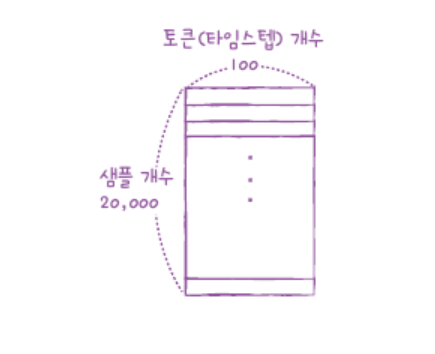

In [16]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


패딩값 0이 없다. -> 앞이나 뒤가 짤렸다.

In [18]:
print(train_input[0][-10:]) # 마지막 10개 토큰

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


뒤가 같으므로 앞이 잘렸음을 알 수 있다. pad__sequences()는 기본으로 maxlen보다 긴 시퀀스의 앞부분을 자른다. 이는 뒷부분의 정보가 더 유용하리라 기대하기 때문이다. (리뷰 끝에 결정적인 소감을 말할 가능성 높음)

만약 뒷부분을 잘라내고 싶다면 pad_sequences()의 truncating 매개변수의 값을 'post'로 지정하면 된다.

In [19]:
# train_seq의 여섯 번째 샘플 출력
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


앞에 패딩이 4개 있는 것으로 보아 이 샘플의 길이는 100이 안된다는 것을 알 수 있다.

순환 신경망의 경우, **시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향**을 미치게 되므로 마지막에 패딩을 추가하는 것은 선호하지 않는다.

In [27]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

케라스에는 여러 순환층 클래스를 제공하는데 그중 가장 간단한 것은 SimpleRNN 클래스이다. 

IMDB 리뷰 분류 문제는 이진 분류이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용해야 한다.

In [20]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500))) # 100은 샘플의 길이, 500은??
model.add(keras.layers.Dense(1, activation='sigmoid'))

순환층도 당연히 활성화 함수를 사용해야 한다. simpleRNN 클래스의 activation 매개변수의 기본값은 tanh로 하이퍼볼릭 탄젠트 함수를 사용한다. (기본값이라 따로 표시하지 않았다.)

그런데 input_shape의 두 번째 차원 500은 어디서 온 것일까?

이전 섹션에서 만든 train)seq와 val_seq에는 한가지 문제가 있다. 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만들게 된다.

이 정수 사이에는 어떤 관련이 없다. 즉, 20번 토큰을 10번 토큰보다 중시해야할 이유가 없다. 따라서 단순한 정수값을 신경망에 입력하기 위해선 다른 방식을 찾아야 한다.

정수값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하는 방법은 원-핫 인코딩이다. 

예를 들어 train_seq[0]의 첫 번째 토큰인 10을 원-핫 인코딩으로 바꾸면 다음과 같다.

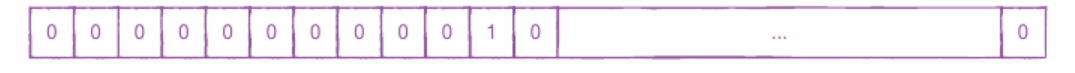

이 배열의 길이가 500이다.

처음 imdb.load_data() 함수에서 500개의 단어만 사용하도록 지정했기 때문에 고유한 단어(어휘사전)는 모두 500개이다. 따라서 표현될 수 있는 정수값의 범위는 0에서 400까지이다. 따라서 500인 것이다.

In [21]:
# 정수배열을 원-핫 인코딩으로 변환
train_oh = keras.utils.to_categorical(train_seq)

In [23]:
print(train_oh.shape)

(20000, 100, 500)


이렇게 정수 하나마다 500차원의 배열로 변경되었기 때문에 입력이 (100,500)이 되어야 하므로 500을 지정해주게 된 것이다. 

In [24]:
print(train_oh[0][0][:12]) # 10을 원-핫 인코딩

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [25]:
print(np.sum(train_oh[0][0])) # 배열의 모든 원소의 합 출력

1.0


In [28]:
# 검증세트도 원-핫 인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [29]:
# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


왜 4,081개일까?

우선 순환층의 뉴런(노드)의 수는 8이다. 각 노드당 500개의 입력이 들어오므로 우선 4000개의 가중치가 있게 된다.

또한 각 뉴런의 은닉 상태가 각 뉴런에게 전달되어 또 다른 가중치와 곱해지므로 각 뉴런당 8개의 가중치가 추가로 있게 된다. 따라서 64개의 가중치가 추가된다. 여기에 각 뉴런마다 절편이 있으므로 8개가 추가된다. 

따라서 4,000 + 64 + 8 = 4,072개의 모델 파라미가 필요하다

## 순환 신경망 훈련하기

여기서 RMSprop의 기본 학습률 0.001을 0.0001로 수정하기 위해 별도의 RMSprop 객체를 만들어 학습률을 0.0001로 지정하였다. 그다음 에포크 횟수를 100으로 늘리고 배치 크기는 64개로 설정했다.

In [32]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 50ms/step - loss: 0.6985 - accuracy: 0.5054 - val_loss: 0.6944 - val_accuracy: 0.5194
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6820 - accuracy: 0.5648 - val_loss: 0.6731 - val_accuracy: 0.5878
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6619 - accuracy: 0.6172 - val_loss: 0.6583 - val_accuracy: 0.6194
Epoch 4/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6451 - accuracy: 0.6445 - val_loss: 0.6443 - val_accuracy: 0.6412
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6297 - accuracy: 0.6636 - val_loss: 0.6337 - val_accuracy: 0.6536
Epoch 6/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6160 - accuracy: 0.6801 - val_loss: 0.6178 - val_accuracy: 0.6750
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6016 - accuracy: 0.6948 - val_loss: 0.6034 - val_ac

검증 세트에 대한 정확도는 약 80%정도이다.

### 훈련 손실과 검증 손실 그래프

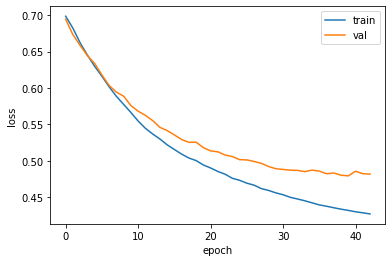

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실은 꾸준히 감소하지만 검증 손실은 약 20번째 에포크부터 감소가 둔해지고 있다. 거의 감소하지 않는 43에서 적절히 훈련을 멈춘 것을 확인할 수 있다. 

# 단어 임베딩 사용하기

원-핫 인코딩의 심각한 단점은 입력 데이터가 엄청 커진다는 점이다.

In [36]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


한 단어당 500개의 배열을 사용하였으므로 데이터의 크기가 500 커지게 된다. 따라서 다른 표현 방법을 사용하는 것이 적절하다.

바로 **단어 임베딩(word embedding)**이다.

단어 임베딩은 단어를 **고정된 크기의 실수 벡터**로 바꾸어준다.

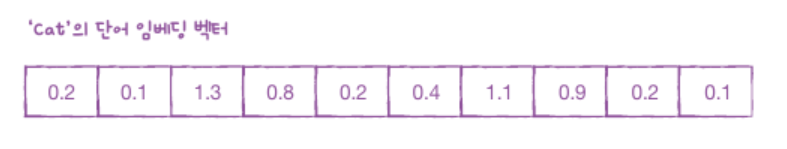

여기에 있는 실수들은 의미있는 값이다. (사전 훈련된 임베딩을 통해 학습 or 직접 학습)

단어 임베딩의 장점은 **입력으로 정수 데이터**를 받는다는 것이다. 즉, 입력이 원핫 인코딩이 아니라 train_seq(단어 인덱스의 배열)를 사용할 수 있다. 

따라서 임베딩은 (100, 16)과 같이 2차원 배열로 늘릴 수 있다. 즉, 한 단어를 16 차원의 벡터로 표현한다는 뜻이다.

In [38]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1,activation='sigmoid'))

In [39]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


embedding층은 (100,) 크기의 입력을 받아 (100,16)의 출력을 만든다.

In [40]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 24ms/step - loss: 0.6740 - accuracy: 0.5910 - val_loss: 0.6494 - val_accuracy: 0.6534
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6334 - accuracy: 0.6851 - val_loss: 0.6265 - val_accuracy: 0.6866
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6047 - accuracy: 0.7213 - val_loss: 0.6021 - val_accuracy: 0.7116
Epoch 4/100
313/313 [==============================] - 8s 26ms/step - loss: 0.5811 - accuracy: 0.7431 - val_loss: 0.5751 - val_accuracy: 0.7472
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5604 - accuracy: 0.7587 - val_loss: 0.5577 - val_accuracy: 0.7546
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.5412 - accuracy: 0.7696 - val_loss: 0.5420 - val_accuracy: 0.7652
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 0.5241 - accuracy: 0.7796 - val_loss: 0.5274 - val_accuracy:

임베딩을 사용한 모델도 약 80% 정도의 정확도를 기록했다. 즉, 원-핫 벡터나 임베딩이나 성능은 비슷하다고 할 수 있겠다. 

하지만 순환층의 가중치 개수가 훨씩 작고 훈련 세트 크기도 훨씬 줄어들게 된다. 

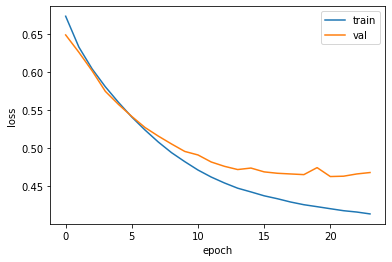

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

보다시피 20에폭 부근에서 검증 손실이 더 감소되지 않아 적절하게 조기종료되었다.